# Bayesian Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.stats import multivariate_normal

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Layer, Dropout, BatchNormalization, LeakyReLU, Lambda
from keras.losses import Loss, mse, MeanSquaredError
from keras.optimizers import Optimizer, Adam
from keras.metrics import Mean
from keras.utils import to_categorical, plot_model, load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras.models import load_model

import tensorflow_probability as tfp

np.random.seed(1234)
tf.random.set_seed(1234)


2023-08-18 11:10:53.162179: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-18 11:10:53.448105: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-18 11:10:53.449765: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 11:10:54.634349: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def printest(args, value):
    return print( "{} : \n {} \n".format(args, value) )

# Exploratory Data Analysis (EDA)

In [3]:
data = pd.read_json('Data/tlc_yellow_trips_2016.json')


In [4]:
data.dropna(inplace = True)

data['pickup_datetime'] = data['pickup_datetime'].str.slice(0, 16)
data['pickup_datetime'] = pd.to_datetime( data['pickup_datetime'], utc = True, format = '%Y-%m-%d %H:%M')

data['dropoff_datetime'] = data['dropoff_datetime'].str.slice(0, 16)
data['dropoff_datetime'] = pd.to_datetime( data['dropoff_datetime'], utc = True, format = '%Y-%m-%d %H:%M')


# Minutes in  a day : 0-1440
data['min_of_day'] = (60*data['pickup_datetime'].dt.hour + data['pickup_datetime'].dt.minute)
# Days in a week: 0-6, where 0 is Monday and 6 Sunday
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
# Days in a year: 1-365 (or 366)
data['day_of_year'] = data['pickup_datetime'].dt.dayofyear
# Time of the  trip
data['trip_duration'] = (data['dropoff_datetime']- data['pickup_datetime']).dt.seconds

# Remove datetime columns
data.drop('pickup_datetime', axis = 1, inplace = True)
data.drop('dropoff_datetime', axis = 1, inplace = True)

## Outliers

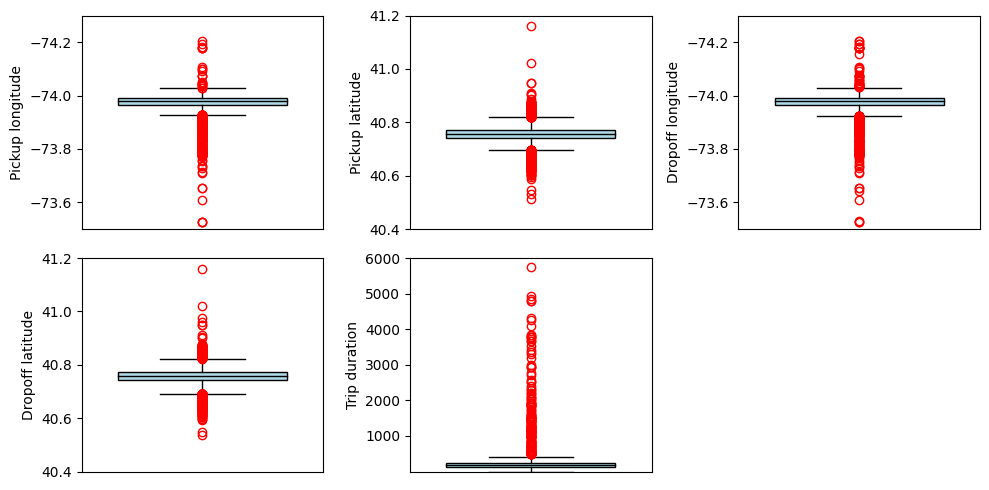

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,5))

ylims = [(-73.5, -74.3), (40.4, 41.2), (-73.5, -74.3), (40.4, 41.2), (1, 6000)] 
attributes = list(zip(list(data.columns[:4]) + ['trip_duration'], ylims))

properties = dict(widths=0.7, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', color='black'),
                  capprops=dict(color='black'),
                  whiskerprops=dict(color='black'),
                  flierprops=dict(color='red', markeredgecolor='red'),
                  medianprops=dict(color='black'))

# Loop over the first five axes
for ax, (columns, ylims) in zip(axes.flatten()[:5], attributes):  
    ax.boxplot(data[columns], **properties)
    ax.set_ylabel(columns.replace('_',' ').capitalize())
    ax.set_ylim(ylims)
    ax.set_xticks([])

# turn off the sixth subplot
axes.flatten()[5].axis('off')

plt.tight_layout()
plt.show()


In [6]:
def outlier_bound(data, r = 1.5):
    q1 = np.percentile(data, 25)
    q2 = np.percentile(data, 50)
    q3 = np.percentile(data, 75)
    iqr = q3-q1

    lower_bound = q1 - r * iqr
    upper_bound = q3 + r * iqr
    return lower_bound, upper_bound


r = 2
lb_p_latitude, ub_p_latitude = outlier_bound(data['pickup_latitude'], r = r)
lb_p_longitude, ub_p_longitude = outlier_bound(data['pickup_longitude'], r = r)
lb_d_longitude, ub_d_longitude = outlier_bound(data['dropoff_longitude'], r = r)
lb_d_latitude, ub_d_latitude = outlier_bound(data['dropoff_latitude'], r = r)
_, ub_t_latitude = outlier_bound(data['trip_duration'], r = 1.5)

markdown_table = f"""
| Attribute           | Lower Bound         | Upper Bound         |

pickup Latitude  :      {lb_p_latitude}      {ub_p_latitude}     
Pickup Longitude :     {lb_p_longitude}      {ub_p_longitude}    
Dropoff Longitude:    {lb_d_longitude}       {ub_d_longitude}    
Dropoff Latitude :    {lb_d_latitude}        {ub_d_latitude}
Trip Duration    :           {1}                  {ub_t_latitude}
    
"""

print(markdown_table)


| Attribute           | Lower Bound         | Upper Bound         |

pickup Latitude  :      40.68001651763916      40.834654808044434     
Pickup Longitude :     -74.0418701171875      -73.91312408447266    
Dropoff Longitude:    -74.04498291015625       -73.90864562988281    
Dropoff Latitude :    40.67546367645264        40.83962440490723
Trip Duration    :           1                  420.0
    



In [7]:
def clip(df, lower_bound, upper_bound, col):
    for c in col:
        df = df[(df[c]>lower_bound) & (df[c]<upper_bound)]
    return df


data = clip(data, 1, 4*ub_t_latitude, ['trip_duration'])
data = clip(data,  lb_p_longitude, ub_p_longitude,
             ['pickup_longitude', 'dropoff_longitude'])
data = clip(data, lb_d_latitude, ub_d_latitude,
             ['pickup_latitude', 'dropoff_latitude'])

data['trip_duration'] = np.log(data['trip_duration'])

# Normalize data
data = (data - data.mean()) / data.std()

data = data.astype('float32')

# Shuffle
data = data.sample(frac=1)

# Separate in- from dependent variables
x = data.drop('trip_duration', axis=1)
y = data['trip_duration']

In [8]:
x.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,min_of_day,day_of_week,day_of_year
28597,-0.454372,0.916533,-0.107535,1.052851,-0.666787,-1.032096,-0.002720
34684,0.724116,0.074928,0.946729,0.225097,0.953797,-0.531150,-0.795656
51632,-0.005614,0.241882,-0.324165,0.256036,1.005822,-1.533043,1.060975
35461,-0.438393,-0.462674,-0.377994,-0.133326,-1.782726,1.472637,0.635497
29870,0.506173,1.268896,0.186556,1.370698,-1.834751,1.472637,0.093980


## Feature distributions

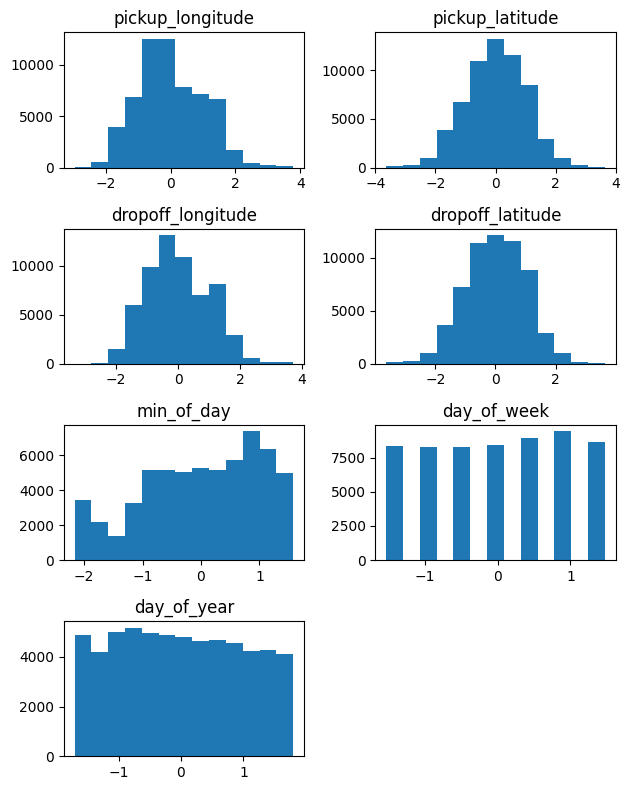

In [9]:
plt.figure(figsize=(6.4, 8))
for i in range(7):
    plt.subplot(4, 2, i+1)
    plt.hist(x.iloc[:, i], 13)
    plt.title(x.columns[i])
plt.tight_layout()
plt.show()


Text(0.5, 0, 'Normalized Trip Duration')

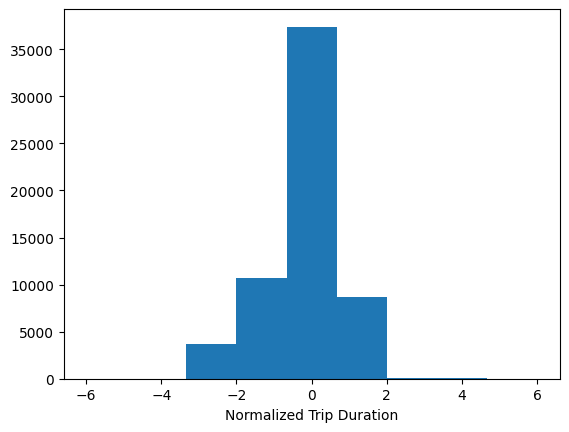

In [10]:
plt.hist(y, bins=np.linspace(-6, 6, 10))
plt.xlabel('Normalized Trip Duration')

# Base Line Models

# Simple Bayesian Neural Network

**variational Bayesian Layer**

This code defines a custom variational Bayesian layer for a neural network. Instead of having fixed weights and biases, each weight and bias is represented as a distribution characterized by mean and standard deviation. These parameters are initialized using Xavier initialization.

During training, the actual values of the weights and biases are stochastically sampled from these distributions. This represents a weight perturbation, where the weights and biases are varied around their mean values according to their standard deviations.

The loss function includes a term for the Kullback-Leibler (KL) divergence, acting as a regularization and guiding the weights and biases towards certain values. In a deterministic forward pass (evaluation mode), the mean values of the distributions could be used directly without sampling.


- During Training (sampling=True): By setting sampling=True, the model samples from the weight and bias distributions. This introduces randomness into the training process, reflecting the uncertainties in the parameters. This stochastic behavior can help the model to explore different regions of the parameter space and can lead to a more robust training process.

- During Prediction (sampling=False): When making predictions, you might want to obtain a single deterministic output. By setting sampling=False, the model uses the mean values of the weight and bias distributions (self.w_loc and self.b_loc), essentially providing the "average" prediction. This gives you a single point estimate that doesn't take into account the uncertainties in the model parameters.


In [11]:
class DenseVariational(Layer):
    def __init__(self, units, activation=None, kl_weight=1e-3, **kwargs):
        """
        Initialize the custom variational dense layer.
        """
        super(DenseVariational, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.kl_weight = kl_weight

    def xavier(self, shape):
        """
        Xavier initialization for the weights and biases.
        """
        return tf.random.truncated_normal(
            shape=shape,
            mean=0.0,
            stddev=np.sqrt(2.0 / sum(shape)))

    def build(self, input_shape):
        """
        Build the layer by defining the variables for means and standard deviations.
        This represents the distributions for the weights and biases.
        """
        d_in = input_shape[-1]
        self.w_mean = tf.Variable(self.xavier((d_in, self.units)), name='w_mean') # Mean for the weight distributions
        self.w_std = tf.Variable(self.xavier((d_in, self.units)) - 5, name='w_std') # Standard deviation for the weight distributions
        self.b_mean = tf.Variable(self.xavier((self.units,)), name='b_mean') # Mean for the bias distributions
        self.b_std = tf.Variable(self.xavier((self.units,)) - 5, name='b_std') # Standard deviation for the bias distributions

    @property
    def weight(self):
        """
        Property representing the weight distributions. This is a collection of normal distributions,
        one for each weight in the layer.
        """
        distribution = tfp.distributions.Normal(self.w_mean, tf.nn.softplus(self.w_std))
        return distribution

    @property
    def bias(self):
        """
        Property representing the bias distributions. This is a collection of normal distributions,
        one for each bias in the layer.
        """
        distribution = tfp.distributions.Normal(self.b_mean, tf.nn.softplus(self.b_std))
        return distribution 


    def call(self, x, Traning = True):
        """
        Perform the forward pass through the layer, either stochastically or deterministically.
        """

        if Traning: # Stochastic foward pass (sampling process)

            w_sample = self.weight.sample()
            b_sample = self.bias.sample() 
            return x @ w_sample + b_sample     
        else: # Deterministic forward pass 
            return x @ self.w_mean + self.b_mean
        
    @property
    def loss(self):
        """
        Compute the loss for the layer, considering the Kullback-Leibler (KL) divergence 
        between the distributions of the weights and biases and a standard normal distribution.
        """

        # Prior distribution
        prior = tfp.distributions.Normal(0, 1)


        kl_w = self.kl_weight*tf.reduce_sum(tfp.distributions.kl_divergence(self.weight, prior))
        kl_b = tf.reduce_sum(tfp.distributions.kl_divergence(self.bias, prior))
        loss = kl_w + kl_b
        return loss

**Flipout Dense Layer**

Flipout helps to reduce the variance of the gradient estimates. In stochastic optimization, the variance of the gradient estimates can slow down convergence and make the training process unstable. By constructing an estimator that has lower variance, Flipout enables more stable and potentially faster convergence.

In traditional Bayesian Neural Networks, sampling different weight realizations from the weight posterior can be computationally expensive, especially when considering mini-batch training. Flipout addresses this challenge by providing an efficient way to decorrelate the gradients within a mini-batch, allowing more informative gradient estimates.

The idea behind Flipout is to use random signs to perturb the weights, and this perturbation is consistent within an example but varies across examples in a mini-batch. The key is that Flipout maintains the expectation of the weights but introduces variation in the mini-batch, thus enabling stochastic training with weight perturbations.

The method achieves this without significantly increasing the computational overhead, making it an appealing way to incorporate stochastic weights into the network. It can be considered as a smart way to approximate the effect of drawing multiple weight samples per mini-batch without actually having to do so, making it more efficient than traditional stochastic weight methods.

In [12]:
class DenseFlipout(Layer):
    def __init__(self, units, activation=None, kl_weight=1e-3, **kwargs):
        """
        Initialize the custom variational dense layer.

        Args:
            units: Number of output units.
            activation: Activation function to use (optional).
            kl_weight: Weighting factor for the KL divergence term in the loss function.
        """
        super(DenseVariational, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.kl_weight = kl_weight

    def xavier(self, shape):
        """
        Xavier initialization for the weights and biases.
        
        Args:
            shape: Shape of the variable being initialized.
        Returns:
            : Initialized variable with truncated normal distribution.
        """
        return tf.random.truncated_normal(
            shape=shape,
            mean=0.0,
            stddev=np.sqrt(2.0 / sum(shape)))

    def build(self, input_shape):
        """
        Build the layer by defining the variables for means and standard deviations.
        This represents the distributions for the weights and biases.

        Args:
            input_shape: Shape of the input to this layer.
        """
        d_in = input_shape[-1]
        self.w_mean = tf.Variable(self.xavier((d_in, self.units)), name='w_mean') # Mean for the weight distributions
        self.w_std = tf.Variable(self.xavier((d_in, self.units)) - 5, name='w_std') # Standard deviation for the weight distributions
        self.b_mean = tf.Variable(self.xavier((self.units,)), name='b_mean') # Mean for the bias distributions
        self.b_std = tf.Variable(self.xavier((self.units,)) - 5, name='b_std') # Standard deviation for the bias distributions

    @property
    def weight(self):
        """
        Property representing the weight distributions. This is a collection of normal distributions,
        one for each weight in the layer.

        Returns: Normal distributions for the weights.
        """
        distribution = tfp.distributions.Normal(self.w_mean, tf.nn.softplus(self.w_std))
        return distribution

    @property
    def bias(self):
        """
        Property representing the bias distributions. This is a collection of normal distributions,
        one for each bias in the layer.

        Returns: 
            Normal distributions for the biases.
        """
        distribution = tfp.distributions.Normal(self.b_mean, tf.nn.softplus(self.b_std))
        return distribution 


    def call(self, x, Traning = True):
        """
        Perform the forward pass through the layer, either stochastically or deterministically.

        Args:
            x: Input tensor to the layer.
            Training: Boolean flag. If True, performs a stochastic forward pass by sampling the weights
                        and biases from their respective distributions. If False, performs a deterministic
                        forward pass using the mean values of the distributions for the weights and biases.

        Returns:
            The output tensor resulting from the forward pass.
        """

        if Traning: # Stochastic foward pass (sampling process)

            w_sample = self.weight.sample()
            b_sample = self.bias.sample() 
            return x @ w_sample + b_sample     
        else: # Deterministic forward pass 
            return x @ self.w_mean + self.b_mean
        
    @property
    def loss(self):
        """
        Compute the loss for the layer, considering the Kullback-Leibler (KL) divergence 
        between the distributions of the weights and biases and a standard normal distribution.

        Returns:
            The loss value as a scalar tensor, representing the sum of the KL divergences 
            for the weights and biases.
        """

        # Prior distribution
        prior = tfp.distributions.Normal(0, 1)
        return (tf.reduce_sum(tfp.distributions.kl_divergence(self.weight, prior)) +
                tf.reduce_sum(tfp.distributions.kl_divergence(self.bias, prior)))


# Distribution Testes

In the Bayesian neural network layer defined in the class BayesianDenseLayer, the standard deviation parameters for both weights and biases are initialized with a value subtracted by 6. The reason for this specific choice is multi-faceted:

The subtraction of 6, followed by the softplus activation, results in small initial standard deviations, creating an almost deterministic behavior in the beginning stages of training. This is beneficial because it helps stabilize the training process early on by preventing the weights from exhibiting excessive variation, which can lead to erratic learning.

Starting with small standard deviations allows the network to begin learning with a strong deterministic assumption and gradually adapt to the appropriate level of uncertainty as training progresses. This approach fosters controlled learning, enabling the network to learn the correct uncertainties over time without being overly influenced by them at the start.

This method of initialization also avoids the problem of large standard deviations leading to sampling extreme weight values, maintaining stability throughout the training.

Overall, this technique reflects a thoughtful approach to initializing a Bayesian neural network, ensuring a balanced and stable learning process by delicately controlling the uncertainty in its parameters from the outset.

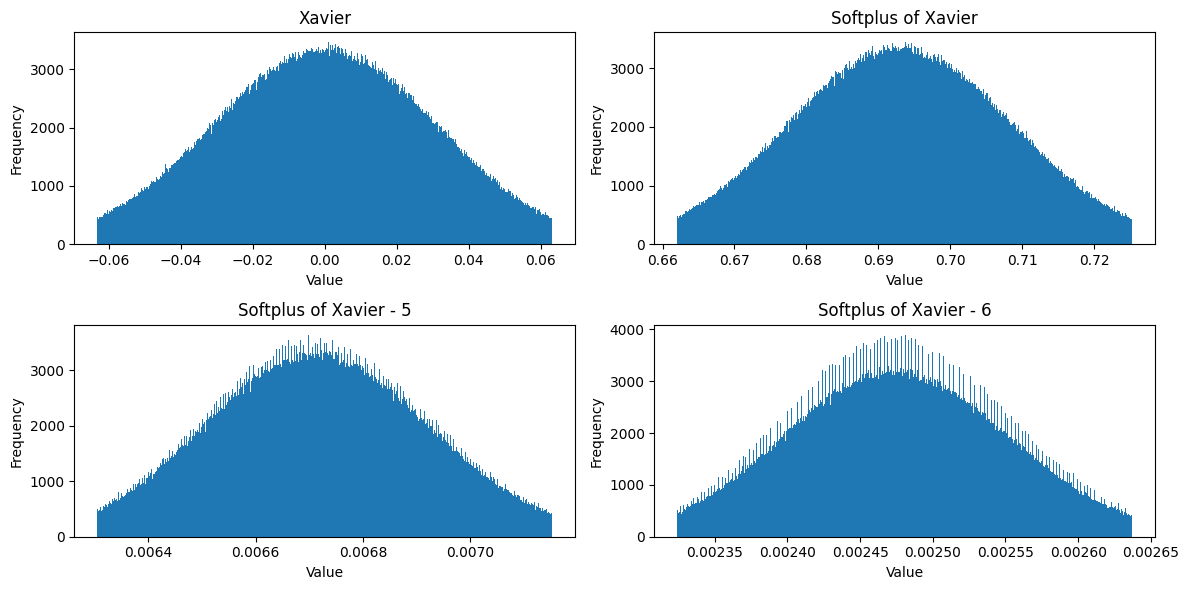

In [14]:
# Test for the Xavier initializer with truncated normal distribution
def xavier(n_in, n_out):
    return tf.random.truncated_normal(
        shape=(n_in, n_out), 
        mean=0.0,
        stddev=np.sqrt(2.0 / (n_in + n_out)))

def plot_histograms(data, titles, bins = 500, nrows = 2, ncols = 2, figsize = (12, 6)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    # Loop over the axes to plot each histogram
    for ax, data, title in zip(axes.flatten(), plot_data, titles):
        ax.hist(data, bins= bins, density=False)
        ax.set_title(title)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

softplus = lambda x: np.log(1 + np.exp(x))

n_in = 1000  
n_out = 1000  
xavier_values = xavier(n_in, n_out)
xavier_values = xavier_values.numpy()

plot_data = [
    xavier_values.flatten()[:,None],
    softplus(xavier_values.flatten()[:,None]),
    softplus(xavier_values.flatten()[:,None]-5),
    softplus(xavier_values.flatten()[:,None]-6)
]

titles = ['Xavier', 'Softplus of Xavier', 'Softplus of Xavier - 5','Softplus of Xavier - 6']


plot_histograms(plot_data, titles)


In this Bayesian neural network implementation, the weights and biases are modeled as random variables following a normal distribution. The `self.weight.sample()` and `self.bias.sample()` methods perform the sampling, allowing the network to consider uncertainty in these parameters.

So When call the `sample()` method on a `tfp.distributions.Normal` object, it performs the sampling using the equation 

$$w_i = \mu_i + \sigma_i \epsilon_i,$$

where $\mu_i$ is the mean, $\sigma_i$ is the standard deviation of the distribution, and $\epsilon_i$ is a random noise term usually sampled from a standard normal distribution, i.e., $\epsilon_i \sim \mathcal{N}(0, 1)$


The following code defines a normal distribution for each weight, with the mean and standard deviation determined by the Xavier initialization.
During each forward step in the training or inference process, actual weight values would be sampled from these distributions.
The plotted PDFs visualize these distributions, showing where the weight values are likely to be sampled from.

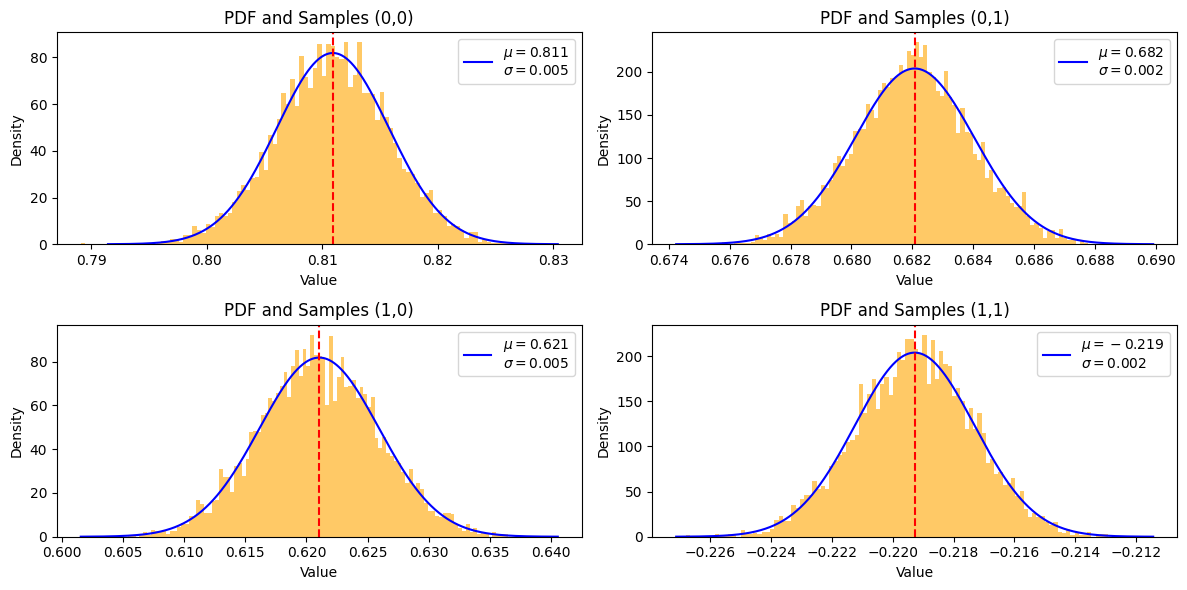

In [15]:
n_in = 2  
n_out = 2
w_mean = xavier(n_in, n_out)
w_std = xavier(2, n_out) - 6


normal_distribution = tfp.distributions.Normal(loc=w_mean, scale=tf.nn.softplus(w_std))


fig, axes = plt.subplots(nrows=n_in, ncols=n_out, figsize=(12, 6))

# Number of samples for each histogram
num_samples = 5000

# Iterate over rows and columns
for i in range(n_in):
    for j in range(n_out):
        # Get mean and standard deviation for specific indices
        mu = w_mean[i, j]
        sigma = tf.nn.softplus(w_std[0, j])

        # Create x values for PDF plotting
        x = np.linspace(float(mu - 4*sigma), float(mu + 4*sigma), 1000)

        # Create a distribution for this specific mean and standard deviation
        single_normal_distribution = tfp.distributions.Normal(loc=mu, scale=sigma)

        # Evaluate PDF
        pdf = single_normal_distribution.prob(x)

        # Draw samples from the distribution
        samples = single_normal_distribution.sample(num_samples)

        # Plot the PDF
        ax = axes[i, j]
        ax.plot(x, pdf, label=f'$\mu = {mu:.3f}$\n$\sigma = {sigma:.3f}$', color='blue')

        # Plot the histogram of samples
        ax.hist(samples, bins=100, density=True, alpha=0.6, color='orange')

        # Draw a vertical line at the mean
        ax.axvline(mu, color='r', linestyle='--')

        ax.set_title(f'PDF and Samples ({i},{j})')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend()

plt.tight_layout()
plt.show()
